In [42]:
"""
Description : Train neural network model to predict one time step of M7
Options:

  --signs=<need_extra_signs_for_log_mass>
  --classification=<train_classification_net>
  --scale=<scaler>
  --model=<model_version>
"""

import numpy as np
from utils import standard_transform_x, standard_transform_y, get_model, train_model, create_report, calculate_stats, log_full_norm_transform_x, log_tend_norm_transform_y, create_dataloader, create_test_dataloader
# from models import Softmax_model
from utils import add_nn_arguments_jupyter
import torch.nn as nn 
import torch
import torch.optim as optim

from sklearn.metrics import mean_squared_error, r2_score

# KB add for active development in models or utils
# %load_ext autoreload
# %autoreload 2

In [125]:
# define full path 
path_to_data = "/home/kim/data/aerosols/aerosol_emulation_data/"

X_test = np.load(path_to_data + 'X_test.npy')
y_test = np.load(path_to_data + 'y_test.npy')

X_train = np.load(path_to_data + 'X_train.npy')
y_train = np.load(path_to_data + 'y_train.npy')

X_valid = np.load(path_to_data + 'X_val.npy')
y_valid = np.load(path_to_data + 'y_val.npy')

# Select the correct 24 columns
X_test_24 = X_test[:, 8:]
X_train_24 = X_train[:, 8:] 

y_test_24 = y_test[:, :24]
y_train_24 = y_train[:, :24]

y_valid_24 = y_valid[:, :24]
X_valid_24 = X_valid[:, 8:]

# How much has it changes between x (at t = 0)  and y (at t = 1)
y_delta_train_24 = y_train_24 - X_train_24
y_delta_test_24 = y_test_24 - X_test_24
y_delta_valid_24 = y_valid_24 - X_valid_24

# Define column indices for each of the components (24 column version)
so4_indices = [0, 1, 2, 3, 4]
bc_indices = [5, 6, 7, 8]
oc_indices = [9, 10, 11, 12]
du_indices = [13, 14, 15, 16]
# What are these indices?!
extra_indices = [17, 18, 19, 20, 21, 22, 23] 

args = add_nn_arguments_jupyter()

# Takes a minute
stats = calculate_stats(X_train, y_train, X_test, y_test, args)

# Look at stats
np.set_printoptions(precision = 4, suppress = True, formatter = {'all': lambda x: f'{x:.4f}'})
stats

{'xtrain_mean': array([43053.9604, 220.3648, 0.4515, 13.3899, 0.1420, 0.1436, 0.0765,
        0.0000, 1693412.4856, 765762.7104, 84252691.7798, 1446742257.3917,
        46672873.0290, 0.0006, 0.0095, 0.0000, 0.0062, 0.0031, 0.0905,
        0.0002, 0.0193, 0.0748, 0.7950, 0.1206, 3.0554, 5872.5780,
        317.3611, 53.0839, 0.3419, 20.2820, 0.7228, 0.7486]),
 'xtrain_std': array([29736.9815, 16.9946, 0.4051, 11.0695, 0.3362, 0.3507, 0.1869,
        0.0000, 5929431.1605, 2599012.2963, 116870184.8104,
        5837074433.2043, 329255434.5922, 0.0013, 0.0833, 0.0003, 0.0553,
        0.0049, 0.6637, 0.0085, 0.1379, 0.7315, 8.0136, 2.4755, 56.2701,
        19559.4708, 513.4709, 133.6869, 2.0570, 151.9586, 14.0062, 11.5913]),
 'ytrain_mean': array([1327825.6655, 809597.8647, 84269109.5843, 1447012439.0770,
        46708025.2049, 0.0006, 0.0095, 0.0000, 0.0062, 0.0031, 0.0905,
        0.0002, 0.0193, 0.0749, 0.7958, 0.1206, 3.0546, 8691.8702,
        317.2871, 53.1025, 0.3421, 20.2323, 0.7226,

In [ ]:
# Not currently using this
extra_indices = [17, 18, 19, 20, 21, 22, 23] 
X_train_24[:, extra_indices].sum(axis = 0)

array([3.35553823e+10, 1.81337293e+09, 3.03316521e+08, 1.95361305e+06,
       1.15889434e+08, 4.13028445e+06, 4.27734393e+06])

# Calculate relative values for softmax

In [132]:
# Define aerosol species and their corresponding indices
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

def normalize_data(XY, indices):
    return XY[:, indices] / XY[:, indices].sum(axis = 1)[..., np.newaxis]

def process_data(X_train, X_valid, X_test, y_train, y_valid, y_test, species_indices):
    for species, indices in species_indices.items():
        # Create variables for relative data
        globals()[f'x_train_{species}_relative'] = normalize_data(X_train, indices)
        globals()[f'y_train_{species}_relative'] = normalize_data(y_train, indices)
        
        globals()[f'x_valid_{species}_relative'] = normalize_data(X_valid, indices)
        globals()[f'y_valid_{species}_relative'] = normalize_data(y_valid, indices)
        
        globals()[f'x_test_{species}_relative'] = normalize_data(X_test, indices)
        globals()[f'y_test_{species}_relative'] = normalize_data(y_test, indices)

        # For R2 and MSE calculations
        globals()[f'y_test_{species}_absolute'] = y_test[:, indices]
        # Used to scale back to OG domain
        globals()[f'x_test_{species}_absolute'] = X_test[:, indices]

# Process the data and create variables
process_data(X_train_24, X_valid_24, X_test_24, y_train_24, y_valid_24, y_test_24, species_indices)

/tmp/ipykernel_143632/3641352552.py:10: RuntimeWarning: invalid value encountered in divide
  return XY[:, indices] / XY[:, indices].sum(axis = 1)[..., np.newaxis]
/tmp/ipykernel_143632/3641352552.py:10: RuntimeWarning: divide by zero encountered in divide
  return XY[:, indices] / XY[:, indices].sum(axis = 1)[..., np.newaxis]


# Remove a few rows from data due to dividion by zero

- This means there is no aersol mass in the cells so we can just remove this.
- x and y data are removed pairwise

In [133]:
for species, indices in species_indices.items():
    ### TRAIN ###
    # Fetch the arrays using globals()
    x_train_species = globals().get(f'x_train_{species}_relative', None)
    y_train_species = globals().get(f'y_train_{species}_relative', None)

    # Extract the indices of the rows with NaN values
    x_train_nan_indices = np.where(np.isnan(x_train_species).any(axis = 1))[0].astype(int)
    y_train_nan_indices = np.where(np.isnan(y_train_species).any(axis = 1))[0].astype(int)

    # Find the union of the two arrays
    train_nan_indices = np.union1d(x_train_nan_indices, y_train_nan_indices)

    # Count the number of rows removed
    rows_removed_train = len(train_nan_indices)

    # Remove the rows from both arrays for the training set
    globals()[f'x_train_{species}_relative'] = x_train_species[~np.isin(np.arange(len(x_train_species)), train_nan_indices)]
    globals()[f'y_train_{species}_relative'] = y_train_species[~np.isin(np.arange(len(y_train_species)), train_nan_indices)]

    # Print the number of rows removed for train set
    print(f"Species: {species} - TRAIN: Removed {rows_removed_train} rows due to NaNs.")

    ### TEST ###
    # Fetch the test arrays using globals()
    x_test_species = globals().get(f'x_test_{species}_relative', None)
    y_test_species = globals().get(f'y_test_{species}_relative', None)
    x_test_species_ABSOLUTE = globals().get(f'x_test_{species}_absolute', None)
    y_test_species_ABSOLUTE = globals().get(f'y_test_{species}_absolute', None)

    # Extract the indices of the rows with NaN values
    x_test_nan_indices = np.where(np.isnan(x_test_species).any(axis = 1))[0].astype(int)
    y_test_nan_indices = np.where(np.isnan(y_test_species).any(axis = 1))[0].astype(int)

    # Find the union of the two arrays
    test_nan_indices = np.union1d(x_test_nan_indices, y_test_nan_indices)

    # Count the number of rows removed
    rows_removed_test = len(test_nan_indices)

    # Remove the rows from both arrays for the test set
    globals()[f'x_test_{species}_relative'] = x_test_species[~np.isin(np.arange(len(x_test_species)), test_nan_indices)]
    globals()[f'y_test_{species}_relative'] = y_test_species[~np.isin(np.arange(len(y_test_species)), test_nan_indices)]
    globals()[f'x_test_{species}_absolute'] = x_test_species_ABSOLUTE[~np.isin(np.arange(len(x_test_species_ABSOLUTE)), test_nan_indices)]
    globals()[f'y_test_{species}_absolute'] = y_test_species_ABSOLUTE[~np.isin(np.arange(len(y_test_species_ABSOLUTE)), test_nan_indices)]

    # Print the number of rows removed for test set
    print(f"Species: {species} - TEST: Removed {rows_removed_test} rows due to NaNs.")

    ### VALID ###
    # Fetch the validation arrays using globals()
    x_valid_species = globals().get(f'x_valid_{species}_relative', None)
    y_valid_species = globals().get(f'y_valid_{species}_relative', None)

    # Extract the indices of the rows with NaN values
    x_valid_nan_indices = np.where(np.isnan(x_valid_species).any(axis = 1))[0].astype(int)
    y_valid_nan_indices = np.where(np.isnan(y_valid_species).any(axis = 1))[0].astype(int)

    # Find the union of the two arrays
    valid_nan_indices = np.union1d(x_valid_nan_indices, y_valid_nan_indices)

    # Count the number of rows removed
    rows_removed_valid = len(valid_nan_indices)

    # Remove the rows from both arrays for the validation set
    globals()[f'x_valid_{species}_relative'] = x_valid_species[~np.isin(np.arange(len(x_valid_species)), valid_nan_indices)]
    globals()[f'y_valid_{species}_relative'] = y_valid_species[~np.isin(np.arange(len(y_valid_species)), valid_nan_indices)]

    # Print the number of rows removed for validation set
    print(f"Species: {species} - VALID: Removed {rows_removed_valid} rows due to NaNs.")

Species: so4 - TRAIN: Removed 0 rows due to NaNs.
Species: so4 - TEST: Removed 0 rows due to NaNs.
Species: so4 - VALID: Removed 0 rows due to NaNs.
Species: bc - TRAIN: Removed 664 rows due to NaNs.
Species: bc - TEST: Removed 62 rows due to NaNs.
Species: bc - VALID: Removed 95 rows due to NaNs.
Species: oc - TRAIN: Removed 249 rows due to NaNs.
Species: oc - TEST: Removed 65 rows due to NaNs.
Species: oc - VALID: Removed 121 rows due to NaNs.
Species: du - TRAIN: Removed 1055 rows due to NaNs.
Species: du - TEST: Removed 402 rows due to NaNs.
Species: du - VALID: Removed 607 rows due to NaNs.


# Loop to make model for each species

In [138]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for species, indices in species_indices.items():
    print(f"Species: {species} - TRAINING COMMENCED")

    ### ARGS ###
    args = add_nn_arguments_jupyter()
    # Overwrite the model name, keep everything else the same
    # Have one model for now as each input dim can be different
    args.model = 'softmax_model'
    args.model_id = 'softmax_' + species # save different models
    # Run for only 3 epochs for proof of concept
    # Took around 2 mins per epoch
    args.epochs = 3 

    ### TRAIN ###
    # Fetch the arrays using globals()
    x_train_species = globals().get(f'x_train_{species}_relative', None)
    y_train_species = globals().get(f'y_train_{species}_relative', None)

    x_valid_species = globals().get(f'x_valid_{species}_relative', None)
    y_valid_species = globals().get(f'y_valid_{species}_relative', None)

    print(x_train_species.shape, x_train_species.shape)

    input_dim = x_train_species.shape[1]
    output_dim = y_train_species.shape[1]

    # Create dataloaders
    train_data_species = create_dataloader(x_train_species, y_train_species, args)
    valid_data_species = create_test_dataloader(x_valid_species, y_valid_species, args)

    # Initalize model
    model = get_model(
        in_features = input_dim, 
        out_features = output_dim, 
        args = args, 
        constraints_active = False)

    if args.mode == 'train':
            
        optimizer = optim.Adam(
                model.parameters(), 
                lr = args.lr, 
                weight_decay = args.weight_decay)

        train_model(
                model = model, 
                train_data = train_data_species, 
                test_data = valid_data_species, # validation
                optimizer = optimizer, 
                input_dim = input_dim, 
                output_dim = output_dim, 
                stats = stats, 
                X_test = X_test, #??
                y_test = y_test, #??
                args = args)
        # Saves the model automatically
    
    ### LOAD trained model ###
    model = get_model(
        in_features = input_dim, out_features = output_dim, args = args, constraints_active = True
        # KB: constraints_active = True This is not used for the softmax model
    ) 
    model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])
    model.to(device)
    # Evaluate
    model.eval()

    # Fetch the test arrays using globals()
    x_test_species = globals().get(f'x_test_{species}_relative', None)
    y_test_species = globals().get(f'y_test_{species}_relative', None)

    x_test_species_absolute = globals().get(f'x_test_{species}_absolute', None)
    y_test_species_absolute = globals().get(f'y_test_{species}_absolute', None)

    # Relative prediction on test
    y_test_species_relative_PRED = model(torch.tensor(x_test_species).to(device).float())
    # Absolue Prediction. Project back using sums from x_test (not y_test itself)
    y_test_species_absolute_PRED = y_test_species_relative_PRED.detach().cpu().numpy() * x_test_species_absolute.sum(axis = 1)[..., np.newaxis]

    # sklearn function, same as np.square(relative_error).mean()
    # relative is implicit in naming
    MSE_rel = mean_squared_error(y_test_species, y_test_species_relative_PRED.detach().cpu().numpy())
    R2_rel = r2_score(y_test_species, y_test_species_relative_PRED.detach().cpu().numpy())
    print(f'Species: {species} | MSE relative:', MSE_rel)
    print(f'Species: {species} | R2 relative:', R2_rel)

    # true, pred
    MSE_abs = mean_squared_error(y_test_species_absolute, y_test_species_absolute_PRED)
    R2_abs = r2_score(y_test_species_absolute, y_test_species_absolute_PRED)
    print(f'Species: {species} | MSE absolute:', MSE_abs)
    print(f'Species: {species} | R2 absolute:', R2_abs)

Species: so4 - TRAINING COMMENCED
(5713910, 5) (5713910, 5)
GPU available: True
Epoch 1, Train Loss: 0.00013
Epoch 1, Val Loss: 0.00002
Epoch 2, Train Loss: 0.00002
Epoch 2, Val Loss: 0.00002
Epoch 3, Train Loss: 0.00002
Epoch 3, Val Loss: 0.00002


/tmp/ipykernel_143632/1173792983.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: so4 | MSE relative: 1.9352746440497093e-05
Species: so4 | R2 relative: 0.9903628594440456
Species: so4 | MSE absolute: 28381060501857.28
Species: so4 | R2 absolute: 0.8491503864072246
Species: bc - TRAINING COMMENCED
(5713246, 4) (5713246, 4)
GPU available: True
Epoch 1, Train Loss: 0.00052
Epoch 1, Val Loss: 0.00073
Epoch 2, Train Loss: 0.00040
Epoch 2, Val Loss: 0.00072
Epoch 3, Train Loss: 0.00040
Epoch 3, Val Loss: 0.00073


/tmp/ipykernel_143632/1173792983.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: bc | MSE relative: 0.00034530206594376604
Species: bc | R2 relative: 0.8911598236612454
Species: bc | MSE absolute: 5.831803390771487e-08
Species: bc | R2 absolute: 0.9730799390200412
Species: oc - TRAINING COMMENCED
(5713661, 4) (5713661, 4)
GPU available: True
Epoch 1, Train Loss: 0.00132
Epoch 1, Val Loss: 0.00484
Epoch 2, Train Loss: 0.00119
Epoch 2, Val Loss: 0.00483
Epoch 3, Train Loss: 0.00119
Epoch 3, Val Loss: 0.00484


/tmp/ipykernel_143632/1173792983.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: oc | MSE relative: 0.00040628098220986197
Species: oc | R2 relative: 0.9144672591784538
Species: oc | MSE absolute: 2.321258736492638e-06
Species: oc | R2 absolute: 0.9632522747270107
Species: du - TRAINING COMMENCED
(5712855, 4) (5712855, 4)
GPU available: True
Epoch 1, Train Loss: 0.17640
Epoch 1, Val Loss: 1.12900
Epoch 2, Train Loss: 0.17625
Epoch 2, Val Loss: 1.12898
Epoch 3, Train Loss: 0.17624
Epoch 3, Val Loss: 1.12897


/tmp/ipykernel_143632/1173792983.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: du | MSE relative: 0.01829193106793996
Species: du | R2 relative: 0.6590220239605113
Species: du | MSE absolute: 0.002282361637267535
Species: du | R2 absolute: 0.9972450902731531


In [167]:
for species, indices in species_indices.items():
    print(f"Species: {species}")
    ### TRAIN ###
    # Fetch the arrays using globals()
    x_train_species = globals().get(f'x_train_{species}_relative', None)
    y_train_species = globals().get(f'y_train_{species}_relative', None)

    x_valid_species = globals().get(f'x_valid_{species}_relative', None)
    y_valid_species = globals().get(f'y_valid_{species}_relative', None)

    print(x_train_species.shape, x_train_species.shape)

    input_dim = x_train_species.shape[1]
    output_dim = y_train_species.shape[1]

    ### ARGS ###
    args = add_nn_arguments_jupyter()
    # Overwrite the model name, keep everything else the same
    # Have one model for now as each input dim can be different
    args.model = 'softmax_model'
    args.model_id = 'softmax_' + species # save different models
    # Run for only 3 epochs for proof of concept
    # Took around 2 mins per epoch
    args.epochs = 3 

    ### LOAD trained model ###
    # Initalize model
    model = get_model(
        in_features = input_dim, 
        out_features = output_dim, 
        args = args, 
        constraints_active = True)# KB: constraints_active = True This is not used for the softmax model

    model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])
    model.to(device)
    # Evaluate
    model.eval()

    # Fetch the test arrays using globals()
    x_test_species = globals().get(f'x_test_{species}_relative', None)
    y_test_species = globals().get(f'y_test_{species}_relative', None)

    x_test_species_absolute = globals().get(f'x_test_{species}_absolute', None)
    y_test_species_absolute = globals().get(f'y_test_{species}_absolute', None)

    y_test_species_absolute_tendencies = y_test_species_absolute - x_test_species_absolute

    # Relative prediction on test
    y_test_species_relative_PRED = model(torch.tensor(x_test_species).to(device).float())
    # Absolue Prediction. Project back using sums from x_test (not y_test itself)
    y_test_species_absolute_PRED = y_test_species_relative_PRED.detach().cpu().numpy() * x_test_species_absolute.sum(axis = 1)[..., np.newaxis]

    # Absolute tendencies: We can use x_test as it is provided
    y_test_species_absolute_tendencies_PRED = y_test_species_absolute_PRED - x_test_species_absolute

    # sklearn function, same as np.square(relative_error).mean()
    # relative is implicit in naming
    MSE_rel = mean_squared_error(y_test_species, y_test_species_relative_PRED.detach().cpu().numpy())
    R2_rel = r2_score(y_test_species, y_test_species_relative_PRED.detach().cpu().numpy())
    print(f'Species: {species} | MSE relative:', MSE_rel)
    print(f'Species: {species} | R2 relative:', R2_rel)

    # true, pred
    MSE_abs = mean_squared_error(y_test_species_absolute, y_test_species_absolute_PRED)
    R2_abs = r2_score(y_test_species_absolute, y_test_species_absolute_PRED)
    R2_abs_tend = r2_score(y_test_species_absolute_tendencies, y_test_species_absolute_tendencies_PRED)
    print(f'Species: {species} | MSE absolute:', MSE_abs)
    print(f'Species: {species} | R2 absolute:', R2_abs)
    print(f'Species: {species} | R2 absolute tendencies:', R2_abs_tend)

Species: so4
(5713910, 5) (5713910, 5)


/tmp/ipykernel_143632/2677372601.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: so4 | MSE relative: 1.9352746440497093e-05
Species: so4 | R2 relative: 0.9903628594440456
Species: so4 | MSE absolute: 28381060501857.28
Species: so4 | R2 absolute: 0.8491503864072246
Species: so4 | R2 absolute tendencies: -53.388559072767656
Species: bc
(5713246, 4) (5713246, 4)


/tmp/ipykernel_143632/2677372601.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: bc | MSE relative: 0.00034530206594376604
Species: bc | R2 relative: 0.8911598236612454
Species: bc | MSE absolute: 5.831803390771487e-08
Species: bc | R2 absolute: 0.9730799390200412
Species: bc | R2 absolute tendencies: -285.54331598730323
Species: oc
(5713661, 4) (5713661, 4)


/tmp/ipykernel_143632/2677372601.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: oc | MSE relative: 0.00040628098220986197
Species: oc | R2 relative: 0.9144672591784538
Species: oc | MSE absolute: 2.321258736492638e-06
Species: oc | R2 absolute: 0.9632522747270107
Species: oc | R2 absolute tendencies: -390.05049082367395
Species: du
(5712855, 4) (5712855, 4)


/tmp/ipykernel_143632/2677372601.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


Species: du | MSE relative: 0.01829193106793996
Species: du | R2 relative: 0.6590220239605113
Species: du | MSE absolute: 0.002282361637267535
Species: du | R2 absolute: 0.9972450902731531
Species: du | R2 absolute tendencies: -2938.9842703934355


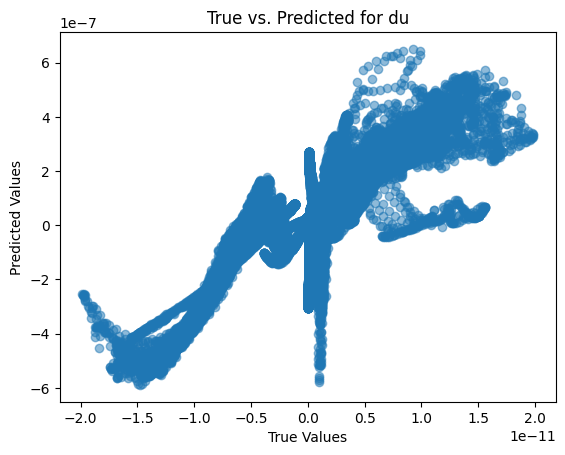

: 

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test_species_absolute_tendencies[0: 20000], y_test_species_absolute_tendencies_PRED[0: 20000], alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"True vs. Predicted for {species}")
# plt.axline((0,0), slope=1, color="red", linestyle = "--")  # y = x reference line
plt.show()

In [152]:
y_test_species_absolute - x_test_species_absolute

array([[-0.0014, -0.0002, -1.7000, 1.7015, 0.0001],
       [-0.0014, -0.0002, -1.7001, 1.7016, 0.0001],
       [-0.0014, -0.0002, -1.7001, 1.7017, 0.0001],
       ...,
       [0.0000, -887.1405, 554.0411, 331.4264, 1.6730],
       [0.0000, -885.6789, 553.1127, 330.8951, 1.6710],
       [-0.0000, -884.1473, 552.1341, 330.3441, 1.6690]])

In [154]:
y_test_species_absolute_PRED - x_test_species_absolute

r2_score(y_test_species_absolute - x_test_species_absolute, y_test_species_absolute_PRED - x_test_species_absolute)

-53.388559072767656

In [150]:
x_test_species_absolute

array([[2.2251, 3.5495, 829749.9519, 7722765.8721, 322.8686],
       [2.2252, 3.5496, 829774.2408, 7722991.9370, 322.8780],
       [2.2253, 3.5497, 829799.4639, 7723226.6966, 322.8878],
       ...,
       [0.0000, 304958.5886, 32981163.9639, 5754415.1765, 2549595.1439],
       [0.0000, 304702.6330, 32945457.6955, 5748017.4590, 2546750.5425],
       [0.0000, 304436.6437, 32908581.3765, 5741462.6129, 2543953.2312]])

In [146]:
x_test_species_absolute

array([[0.0001, 0.0000, 0.0000, 0.0000],
       [0.0001, 0.0000, 0.0000, 0.0000],
       [0.0001, 0.0000, 0.0000, 0.0000],
       ...,
       [0.0003, 0.0029, 0.0000, 0.0000],
       [0.0003, 0.0029, 0.0000, 0.0000],
       [0.0003, 0.0029, 0.0000, 0.0000]])

In [140]:
np.mean([0.9972, 0.963, 0.973, 0.849])

0.9455499999999999

In [117]:
print(x_train_so4_relative.shape, y_valid_so4_relative.shape)
# For the original it is (5713910, 28) (2856955, 28)
    
train_data_so4 = create_dataloader(x_train_so4_relative, y_train_so4_relative, args)
# validation data
val_data_so4 = create_test_dataloader(x_valid_so4_relative, y_valid_so4_relative, args)

input_dim = x_train_so4_relative.shape[1]
output_dim = y_train_so4_relative.shape[1]

(5713910, 5) (2856955, 5)


# Simplified version with no conditioning

- because we don't know what the additional variables are

In [ ]:
print(args)

# Overwrite the model name, keep everything else the same
# Have one model for now as each input dim can be different
args.model = 'softmax_model'
args.model_id = 'softmax_test' # why not train
# Run for only 3 epochs for proof of concept
# Took around 2 mins per epoch
args.epochs = 3 

print(args)

Namespace(mode='train', signs=False, scale='z', model='softmax_model', model_id='standard_test', log=False, lr=0.001, width=128, depth=2, loss='mse', optimizer='adam', weight_decay=1e-09, batch_size=256, epochs=100, early_stop=False, save_val_scores=False, old_data=False)
Namespace(mode='train', signs=False, scale='z', model='softmax_model', model_id='standard_test', log=False, lr=0.001, width=128, depth=2, loss='mse', optimizer='adam', weight_decay=1e-09, batch_size=256, epochs=3, early_stop=False, save_val_scores=False, old_data=False)


In [19]:
model = get_model(
    in_features = input_dim, 
    out_features = output_dim, 
    args = args, 
    constraints_active = False)

if args.mode == 'train':
        
    optimizer = optim.Adam(
            model.parameters(), 
            lr = args.lr, 
            weight_decay = args.weight_decay)

    train_model(
            model = model, 
            train_data = train_data_so4, 
            test_data = val_data_so4, # validation
            optimizer = optimizer, 
            input_dim = input_dim, 
            output_dim = output_dim, 
            stats = stats, 
            X_test = X_test, 
            y_test = y_test, 
            args = args)

# prints an MSE in relative space

GPU available: True
Epoch 1, Train Loss: 0.00014
Epoch 1, Val Loss: 0.00002
Epoch 2, Train Loss: 0.00002
Epoch 2, Val Loss: 0.00002
Epoch 3, Train Loss: 0.00002
Epoch 3, Val Loss: 0.00002


# After training

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.set_printoptions(precision = 6, suppress = True, formatter = {'all': lambda x: f'{x:.6f}'})

model = get_model(
    in_features = input_dim, out_features = output_dim, args = args, constraints_active = True
    # KB: constraints_active = True This is not used for the softmax model
    ) 
model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])
model.to(device)
model.eval()
# create_report(model, x_test_so4_relative, y_test_so4_relative, stats, args)

y_test_so4_relative_PRED = model(torch.tensor(x_test_so4_relative).to(device).float())

# Absolute error. Project back using sums from x_test (not y_test itself)
y_test_so4_absolute_PRED = y_test_so4_relative_PRED.detach().cpu().numpy() * X_test_24[:, so4_indices].sum(axis = 1)[..., np.newaxis]

# sklearn function, same as np.square(relative_error).mean()
# with relative_error = (y_test_so4_relative - y_test_so4_relative_PRED.detach().cpu().numpy())
MSE_rel = mean_squared_error(y_test_so4_relative, y_test_so4_relative_PRED.detach().cpu().numpy())
print('MSE relative:', MSE_rel)

MSE_abs = mean_squared_error(y_test_so4_absolute_PRED, y_test_so4_absolute)
R2_abs = r2_score(y_test_so4_absolute_PRED, y_test_so4_absolute)
print('MSE absolute:', MSE_abs)
print('R2 absolute:', R2_abs)

/tmp/ipykernel_143632/666518117.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/' + args.model_id + '.pth') ['state_dict'])


MSE relative: 1.78921866465961e-05
MSE absolute: 19178658378338.836
R2 absolute: 0.8855318965675775


In [54]:
print(y_test_so4_absolute_PRED[0])
print(y_test_so4_relative_PRED[0])

[0.000209 0.000180 0.095894 0.903096 0.000621]
tensor([2.0861e-04, 1.8009e-04, 9.5894e-02, 9.0310e-01, 6.2118e-04],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
X_train_24[:, so4_indices].sum(axis = 1)[..., np.newaxis]

(5713910, 1)

In [52]:
y_test_so4_absolute[0]

array([2.223691, 3.549291, 829748.251939, 7722767.573677, 322.868651])

In [45]:
np.square(relative_error).mean()

1.789218664659599e-05